In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import torch
import numpy as np
import scipy as sp
import math
import copy
from matplotlib import pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm

from test_sampler import TestProblem, TestProblem2
from optimize_algos import test_algo_by_problem, ACRCD, ACRCD_star, just_USTM

## TEST ACRCD

In [11]:
problem_1 = TestProblem(x_dim=10, y_dim=100, gamma=5, svxpy_verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 18 01:55:26 PM: Your problem has 110 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 18 01:55:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 18 01:55:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 18 01:55:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 18 01:55:26 PM: Compiling problem (target solver=SCS).
(CVXPY) Jul 18 01:55:26 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

100%|██████████| 5000/5000 [00:07<00:00, 691.00it/s]


start f val:  22.56548309326172
result val:  22.562166
grad x norm:  0.002516286
grad y norm:  0.0031031556
solver/analytic f*:  22.56216602043049
start, end L1:  100 200.0
start, end L2:  100 100.0


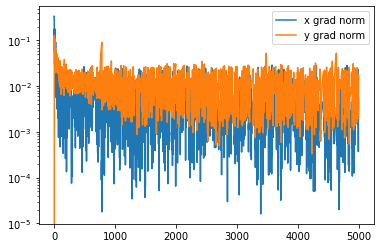

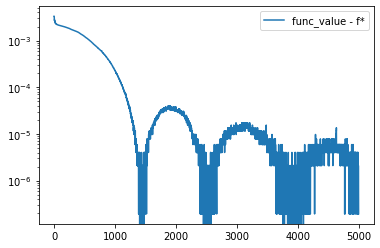

In [33]:
test_algo_by_problem(test_problem=problem_1, algo_func=ACRCD_star, L1_init=100, L2_init=100)

## TEST USTM

100%|██████████| 5000/5000 [00:09<00:00, 527.85it/s]


start f val:  22.565483
result val:  22.564732
grad norm:  0.18175438
solver/analytic f*:  22.56216602043049
start, end L:  0.033867049217224124 0.1354681968688965


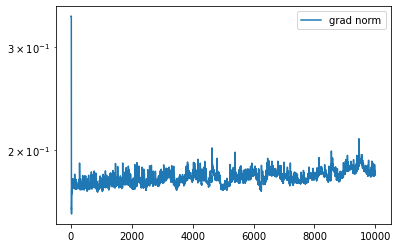

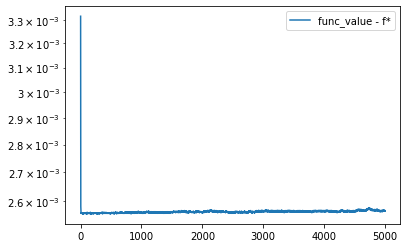

In [34]:
test_problem = problem_1

x0 = np.zeros(test_problem.x_dim + test_problem.y_dim)
t_history, value_log, grad_history, A_log, (start_L, L_value) = \
    just_USTM(test_problem, x0,
              eps_abs=1e-6,
              max_iter=5000)

res_f, grad = test_problem.calc_by_one_block(t_history[-1])

print("start f val: ", value_log[0])
print("result val: ", res_f)
print("grad norm: ", np.linalg.norm(grad))
print("solver/analytic f*: ", test_problem.f_star)
print("start, end L: ", start_L, L_value)

plt.plot(grad_history, label='grad norm')
plt.yscale("log")
plt.legend()
plt.show()

plt.plot(np.array(value_log)-test_problem.f_star, label="func_value - f*")
plt.yscale("log")
plt.legend()
plt.show()

# Вторая задача (решается аналитически)
## ACRCD - правильные L

In [17]:
problem_2 = TestProblem2(La=100, Lb=10)

100%|██████████| 5000/5000 [00:02<00:00, 1675.04it/s]


start f val:  0.0
result val:  -2321.6600741761845
grad x norm:  0.16097885488690367
grad y norm:  0.40342297477604727
solver/analytic f*:  -2331.093288221011
start, end L1:  100 100
start, end L2:  10 10


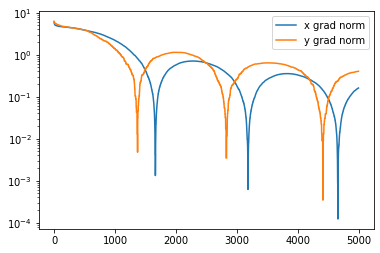

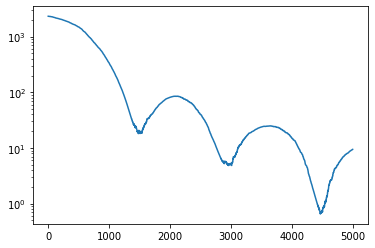

In [18]:
test_algo_by_problem(test_problem=problem_2, algo_func=ACRCD, L1_init=problem_2.La, L2_init=problem_2.Lb)

## ACRCD - неправильные L

100%|██████████| 5000/5000 [00:02<00:00, 1776.93it/s]


start f val:  0.0
result val:  1.3261584378905158e+275
grad x norm:  5.150064927533469e+138
grad y norm:  0.05611425255192993
solver/analytic f*:  -2331.093288221011
start, end L1:  50.0 50.0
start, end L2:  10 10


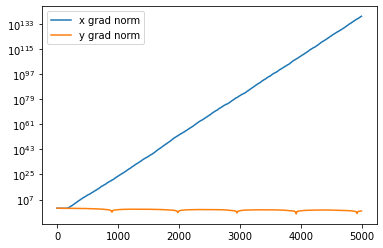

ValueError: cannot convert float NaN to integer

<Figure size 432x288 with 1 Axes>

100%|██████████| 5000/5000 [00:02<00:00, 1862.53it/s]


start f val:  0.0
result val:  3.011339139593473e+284
grad x norm:  2.4541145611374686e+143
grad y norm:  0.19404952181791732
solver/analytic f*:  -2331.093288221011
start, end L1:  50.0 50.0
start, end L2:  10 10


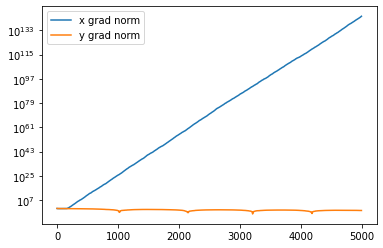

ValueError: cannot convert float NaN to integer

<Figure size 432x288 with 1 Axes>

In [22]:
test_algo_by_problem(test_problem=problem_2, algo_func=ACRCD, L1_init=problem_2.La/2, L2_init=problem_2.Lb)

## ACRCD* - неправильные L

100%|██████████| 5000/5000 [00:07<00:00, 688.85it/s]


start f val:  0.0
result val:  -2331.082717657984
grad x norm:  0.017940404203749254
grad y norm:  0.0075081472582112264
solver/analytic f*:  -2331.093288221011
start, end L1:  50.0 50.0
start, end L2:  10 10.0


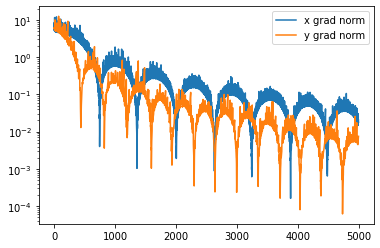

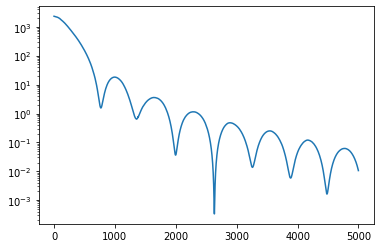

In [20]:
test_algo_by_problem(test_problem=problem_2, algo_func=ACRCD_star, L1_init=problem_2.La/2, L2_init=problem_2.Lb)

# Первая задача (решается солвером)
# ACRCD

100%|██████████| 5000/5000 [00:03<00:00, 1444.74it/s]


start f val:  -0.009782673791050911
result val:  0.83881074
grad x norm:  16.531113
grad y norm:  6.271242
solver/analytic f*:  -0.09913493432146778
start, end L1:  100 100
start, end L2:  100 100


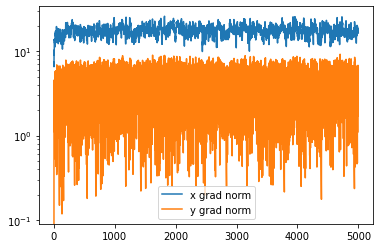

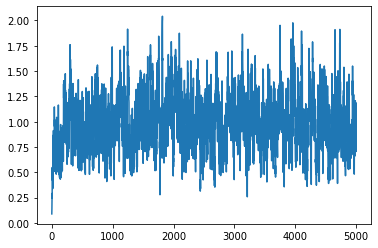

In [8]:
test_algo_by_problem(test_problem=problem_1, algo_func=ACRCD, L1_init=100, L2_init=100)

100%|██████████| 5000/5000 [00:06<00:00, 778.09it/s]


start f val:  -0.009782673791050911
result val:  -0.09913492
grad x norm:  0.0020384747
grad y norm:  0.002005721
solver/analytic f*:  -0.09913493432146778
start, end L1:  100 400.0
start, end L2:  100 100.0


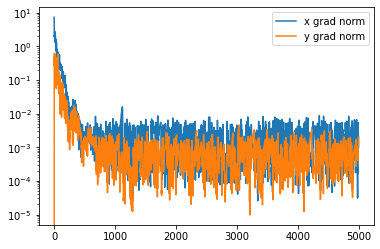

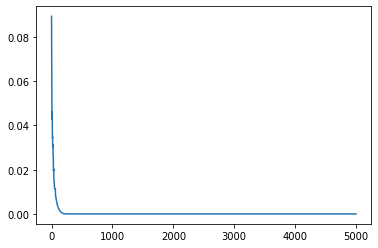

In [9]:
test_algo_by_problem(test_problem=problem_1, algo_func=ACRCD_star, L1_init=100, L2_init=100)